In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
# Load MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [0]:
# Leaky ReLU
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, kernel_initializer="he_normal"))
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))


In [0]:
# PReLU
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, kernel_initializer="he_normal"))
model.add(keras.layers.PReLU())
model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
model.add(keras.layers.PReLU())
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))


In [0]:
# ELU
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="elu"))
model.add(keras.layers.Dense(100, activation="elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

In [0]:
# SELU with 100 layers
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))


model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

# Standardize the input
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds


history = model.fit(X_train_scaled, y_train, epochs=100,
                    validation_data=(X_valid_scaled, y_valid))

In [0]:
# Swish activation
from keras import backend as K
import numpy as np

def swish_activation(x, beta=1):
  return x * K.sigmoid(beta*x)

import matplotlib.pyplot as plt

# Test the swish function
beta = 0.8
x = np.linspace(-5, 5, 100)
y = swish_activation(x, beta)

plt.figure()
plt.plot(x, y)

In [0]:
# Batch normalization
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))

In [0]:
# Batch normalization (before activation function)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.Activation("relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))

In [0]:
### Reuse pretrained net
import numpy as np

# Split the dataset
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

# Model A
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

In [0]:
# Model B, reuse model A
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

# Freeze all layers and train a bit to have stable weights
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

# Unfreeze and train
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

In [0]:
# Baseline scheduling
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 20

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

In [0]:
# Exponential scheduling
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.001, s=20)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 20

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

In [0]:
# Performance scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

In [0]:
# 1cycle scheduling
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

batch_size = 32
n_epochs = 20
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

In [0]:
# l2 regularization
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="selu",
                           kernel_initializer="lecun_normal",
                           kernel_regularizer=keras.regularizers.l2(0.00001))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

In [0]:
# Cifar-10
# Load the dataset
from keras.datasets import cifar10
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
x_train = x_train_full[:40000]
y_train = y_train_full[:40000]
x_validation = x_train_full[40000:] / 255.
y_validation = y_train_full[40000:]

In [0]:
######### Use subclassing API to build a network from scratch ##########
from tensorflow import keras

#### Data augmentation
from keras.preprocessing.image import ImageDataGenerator

# Create the augmentation generator
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),
    channel_shift_range=0.2,
    horizontal_flip=True,)
train_datagen.fit(x_train)

# Note that the validation data should not be augmented!
train_generator = train_datagen.flow(
        x_train, y_train,
        batch_size=32)

# Make a custom block of convoluation, batch norm and drop out
class ConvAndMaxPoolBlock(keras.layers.Layer):
 def __init__(self, input_shape=[], n_channel=32, kernel_size = (2, 2), activation='relu',
              l2_weight=0.01, pool_size=(2,2), stride=(1, 1), dropout_rate=0.2, **kwargs):
   super().__init__(**kwargs)
   self.n_channel = n_channel
   self.conv_layer = keras.layers.Conv2D(filters=n_channel, input_shape=input_shape, kernel_size=kernel_size, strides=stride, kernel_regularizer=keras.regularizers.l2(l2_weight), padding='same')
   self.batch_norm_layer = keras.layers.BatchNormalization()
   self.dropout_layer = keras.layers.Dropout(rate=dropout_rate)
   self.activation_layer = keras.layers.Activation(activation)
   self.maxpool_layer = keras.layers.MaxPool2D(pool_size=pool_size)

 def call(self, inputs):
   Z = inputs
   Z = self.conv_layer(Z)
   Z = self.batch_norm_layer(Z)
   Z = self.activation_layer(Z)
   Z = self.dropout_layer(Z)
   Z = self.maxpool_layer(Z)
   return Z

 def get_config(self):                                               
   base_config = super().get_config()                              
   return {**base_config,                                          
            "n_channels": self.n_channel}

# Make a custom model
class MyCustomModel(keras.Model):
  def __init__(self, input_shape, output_dim, l2_weight, dropout_rate, **kwargs):
    super().__init__(**kwargs)
    self.output_dim = output_dim
    self.block1 = ConvAndMaxPoolBlock(n_channel=32, input_shape = input_shape, kernel_size = (3, 3), activation='relu', l2_weight=l2_weight, dropout_rate=dropout_rate, pool_size=(2,2))
    self.block2 = ConvAndMaxPoolBlock(n_channel=64, kernel_size = (5, 5), activation='relu', l2_weight=l2_weight, dropout_rate=dropout_rate, pool_size=(2,2))
    self.block3 = ConvAndMaxPoolBlock(n_channel=128, kernel_size = (7, 7), activation='relu', l2_weight=l2_weight, dropout_rate=dropout_rate, pool_size=(2,2))
    self.block4 = ConvAndMaxPoolBlock(n_channel=256, kernel_size = (9, 9), activation='relu', l2_weight=l2_weight, dropout_rate=dropout_rate, pool_size=(2,2))    
    self.globpool_layer = keras.layers.GlobalAveragePooling2D()
    self.out_layer = keras.layers.Dense(output_dim, activation='softmax')

  def call(self, inputs):
    Z = inputs
    Z = self.block1(Z)
    Z = self.block2(Z)
    Z = self.block3(Z)
    Z = self.block4(Z)
    Z = self.globpool_layer(Z)
    return self.out_layer(Z)

  def get_config(self):                                           
    base_config = super().get_config()                           
    return {**base_config,                                       
            "output_dim": self.output_dim}    

# Create the model
l2_weight = 0.0
dropout_rate = 0.2
model = MyCustomModel(input_shape=x_train[0].shape, output_dim=10, l2_weight=l2_weight, dropout_rate=dropout_rate)


# Compile the model
early_stopping_cb = keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True, monitor='val_loss')
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with augmentation
history = model.fit(
      train_generator,
      steps_per_epoch=x_train.shape[0] / 32,
      epochs=100,
      validation_data=(x_validation, y_validation), 
      callbacks=[early_stopping_cb])

# Train without augmentation
# history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=100, callbacks=[early_stopping_cb])

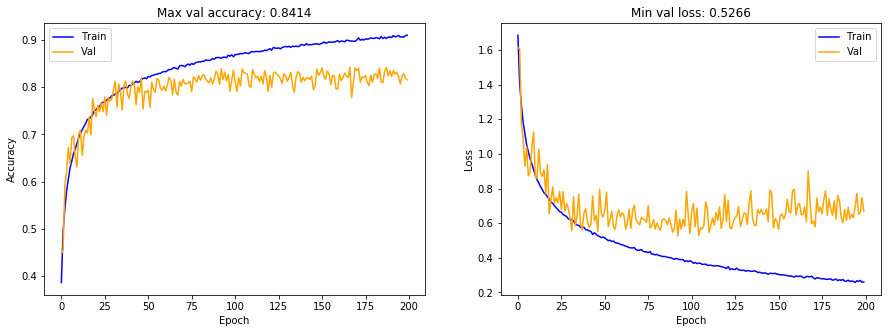

In [0]:
# A plotting function you can reuse
import matplotlib.pyplot as plt

def plot_training(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))
  fig = plt.figure(figsize=(15, 5))
  ax1 = fig.add_subplot(121)
  plt.title('Max val accuracy: {0:.4f}'.format(max(val_acc)))
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  ax1 = fig.add_subplot(122)
  plt.title('Min val loss: {0:.4f}'.format(min(val_loss)))
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot_training(history)

In [0]:
############# Use pretrained MobileNetV2 
# Resize the images
x_train_resize = tf.image.resize(
                        x_train / 255.,
                        [96, 96],
                        method='bilinear',
                        preserve_aspect_ratio=False,
                        antialias=True)

x_validation_resize = tf.image.resize(
                        x_validation,
                        [96, 96],
                        method='bilinear',
                        preserve_aspect_ratio=False,
                        antialias=True)

#### Data augmentation
from keras.preprocessing.image import ImageDataGenerator

# Create the augmentation generator
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),
    channel_shift_range=0.2,
    horizontal_flip=True,)
train_datagen.fit(x_train_resize)

# Note that the validation data should not be augmented!
train_generator = train_datagen.flow(
        x_train_resize, y_train,
        batch_size=32)

# Load the base model
base_model = tf.keras.applications.MobileNetV2(input_shape=x_train_resize[0].shape,
                                               include_top=False,
                                               weights='imagenet')

# freeze all weights
base_model.trainable = False 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')

# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

# Compile the model and train the last layer
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_generator, validation_data=(x_validation_resize, y_validation), epochs=20)

In [0]:
# Unfreeze some layers and train everything again
model.trainable = True
max_layer_freeze = 60
for layer in base_model.layers[:max_layer_freeze]:
  layer.trainable = False

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_generator, validation_data=(x_validation_resize, y_validation), epochs=100)